In [1]:
import os, json, random
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from typing import Any, Dict, Optional, Tuple, Union, List
from collections import Counter, defaultdict
import numpy as np
from tqdm import tqdm, trange
from transformers import ViTForImageClassification
import pytz
from datetime import datetime
timezone = pytz.timezone('America/New_York') 

In [2]:
PATH = "<largefiles_dir>/skewed_relations_T2I/", # [Important]: update this to the correct path

In [3]:
from transformers import ViTImageProcessor
model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)

from datasets import load_metric
metric = load_metric("accuracy")


/tmp/ipykernel_3924994/3253253806.py:6: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [4]:
def get_acc(output, gth, verbose=False):
    output, gth = output.detach().cpu(), gth.detach().cpu()
    if verbose:
        print("pred = ", np.argmax(output, axis=1))
        print("gth  = ", gth)
    return metric.compute(predictions=np.argmax(output, axis=1), references=gth)['accuracy'], np.argmax(output, axis=1)

def collate_fn(batch):
    inputs = {}
    inputs['pixel_values'] = processor([x['image'] for x in batch], return_tensors='pt')['pixel_values']
    inputs['label'] = torch.LongTensor([x['label'] for x in batch])
    return inputs

### Finetune ViT

In [5]:
class dataset(Dataset):
    def __init__(self,
                 classes: List[str], # used to define class_ids, order matters
                 imdir: str,
                 data: List,
                 imsize = 64,
                 ):
        super().__init__()
        self.imdir = imdir
        self.data = data ## should be a list of tuples, e.g. (text, image, (mug, cup, left of))
        self.imsize = imsize

        #self.classes = classes
        self.classes = ["empty"]+classes
        self.n2i = {n:i for i, n in enumerate(self.classes)}

    def __len__(self): return len(self.data)*2
    
    def __getitem__(self, i): 
        text, image_path, tuple = self.data[i//2]

        # center crop to a square, then resize
        image = Image.open(os.path.join(self.imdir, image_path))
        width, height = image.size
        new_dimension = min(image.size)
        left = (width - new_dimension)/2
        top = (height - new_dimension)/2
        right = (width + new_dimension)/2
        bottom = (height + new_dimension)/2
        image = image.crop((left, top, right, bottom)).resize((self.imsize, self.imsize))
        
        H, W = self.imsize, self.imsize

        if tuple[-1] in ['left of', 'right of']:
            crop1 = image.crop((0, H//4, W//2, 3*H//4))
            crop2 = image.crop((W//2, H//4, W, 3*H//4))

            crop3 = image.crop((W//4, 0, 3*W//4, H//2))
            crop4 = image.crop((W//4, H//2, 3*W//4, H))
        else:
            crop1 = image.crop((W//4, 0, 3*W//4, H//2))
            crop2 = image.crop((W//4, H//2, 3*W//4, H))

            crop3 = image.crop((0, H//4, W//2, 3*H//4))
            crop4 = image.crop((W//2, H//4, W, 3*H//4))

        f1, f2 = self.n2i[tuple[0]], self.n2i[tuple[1]]
        if tuple[-1] in ['right of', 'in-front of']:
            f1, f2 = f2, f1
        f3, f4 = 0, 0
        image = [crop1, crop2, crop3, crop4][i%4]
        label = [f1, f2, f3, f4][i%4]

        """
        dataset return
        {
            "image": pilimage,
            "labels": int
        }
        """
        # res = {
        #     "sentence": text,
        #     'image': crop2 if i%2 else crop1,
        #     'label': f2 if i%2 else f1,
        # }
        res = {
            "sentence": text,
            'image': image,
            'label': label,
        }
        return res


In [6]:
J = json.load(open("../data/aggregated/whatsup_vlm_b.json", "r"))
annotations = []
for a in J:
    if a[-1][0] in ["sunglasses", "remote", "phone"] or a[-1][1] in ["sunglasses", "remote", "phone"]: continue
    else: annotations.append(a)
occurrences = [a[-1][0] for a in annotations] + [a[-1][1] for a in annotations]
c = Counter(occurrences)

classes = sorted(c.keys(), key=lambda x: (-c[x], x))

print(classes)
# Each whatsup image contains two objects. 
# We will resize the image to 64x64, and take two 32x32 single-obj crops
D = dataset(
    classes, 
    imdir = os.path.join(PATH, "data"),
    data = annotations,
    imsize=64 
)

train_ratio = 0.9
train_num = int(train_ratio*len(D))
val_num = len(D) - train_num
train_data, val_data = random_split(D, [train_num, val_num])
print(f"{len(train_data)} training examples, {len(val_data)} testing examples")

['book', 'bowl', 'can', 'cap', 'cup', 'mug', 'plate', 'candle', 'flower', 'fork', 'headphones', 'knife', 'scissors', 'spoon', 'tape']
554 training examples, 62 testing examples


In [7]:
def train(net, dataloader, optimizer, criterion, device):
    net.train()
    running_loss, running_acc = [], []
    for batch in tqdm(dataloader):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        bs = len(batch['pixel_values'])
        outputs = net(batch['pixel_values'].to(device))['logits']# (bs, outputs_per_sample*num_classes)

        labels = batch['label'].to(device)

        loss = criterion(outputs, labels)
        acc, _ = get_acc(outputs, labels)

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss.append(loss.item())
        #print(acc)
        running_acc.append(acc)
    return np.mean(running_loss), np.mean(running_acc)

def val(net, dataloader, criterion, device, verbose):
    net.eval()
    epoch_loss, epoch_acc = [], []

    with torch.no_grad():
        for batch in dataloader:
            bs = len(batch['pixel_values'])
            outputs = net(batch['pixel_values'].to(device))['logits'] # (bs, outputs_per_sample*num_classes)

            labels = batch['label'].to(device)

            loss = criterion(outputs, labels)
            acc, _ = get_acc(outputs, labels, verbose=verbose)

            # print statistics
            epoch_loss.append(loss.item())
            epoch_acc.append(acc)
        
    return np.mean(epoch_loss), np.mean(epoch_acc)

In [8]:
labels = D.classes

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)
device = "cuda"
model.to(device)
print()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
print(labels)

['empty', 'book', 'bowl', 'can', 'cap', 'cup', 'mug', 'plate', 'candle', 'flower', 'fork', 'headphones', 'knife', 'scissors', 'spoon', 'tape']


In [10]:
batch_size=16
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=2)
testloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=2)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-4) #, momentum=0.9)

In [11]:
print("pilimage image size from dataset.__getitem__(): ", train_data[0]['image'].size)
batch = next(iter(trainloader))
print("image tensor size after processor", batch['pixel_values'].size())

pilimage image size from dataset.__getitem__():  (32, 32)


image tensor size after processor torch.Size([16, 3, 224, 224])


In [12]:
best_val_loss = float('inf')
best_val_acc = 0.0
verbose=False
print("num_classes = ", len(labels))

save_to_dir = os.path.join(PATH, "autoeval")
date = datetime.now(timezone).strftime("%m%d_%H%M%S")
for epc in range(10):

    train_loss, train_acc = train(model, trainloader, optimizer, criterion, device)
    val_loss, val_acc = val(model, testloader, criterion, device, verbose)

    if val_acc >= best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), os.path.join(save_to_dir, "{}_{}.pt".format(model_name_or_path.split("/")[-1], date)))
    
    print(f'Epoch: {epc+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')
    
print("Training: finish\n")



num_classes =  16


100%|██████████| 35/35 [00:08<00:00,  4.30it/s]


Epoch: 01
	Train Loss: 1.434 | Train Acc: 66.14%
	 Val. Loss: 0.672 |  Val. Acc: 93.75%


100%|██████████| 35/35 [00:06<00:00,  5.45it/s]


Epoch: 02
	Train Loss: 0.462 | Train Acc: 96.96%
	 Val. Loss: 0.374 |  Val. Acc: 98.44%


 26%|██▌       | 9/35 [00:02<00:06,  3.95it/s]


KeyboardInterrupt: 

### Test Finetuned ViT on Generated Samples (singleobj)

In [14]:
#18 objs in original whatsup dataset (plus 'empty')
#classes = ['empty', 'mug', 'plate', 'book', 'bowl', 'can', 'cap', 'cup', 'remote', 'sunglasses', 
#          'tape', 'candle', 'flower', 'fork', 'headphones', 'scissors', 'spoon', 'knife', 'phone']

#15 objs (plus 'empty') after removing sunglasses, remote, phone
classes = ['empty', 'book', 'bowl', 'can', 'cap', 'cup', 'mug', 'plate', 'candle', 'flower', 'fork', 'headphones', 'knife', 'scissors', 'spoon', 'tape']

n2i = {n:i for i, n in enumerate(classes)}
device = "cuda"
ckpt_dir = os.path.join(PATH, "autoeval/vit-base-patch16-224-in21k_0311_211459.pt")

In [15]:
handle = "0304_002415" #"0514_083120"
whichset="test"
output_folder="output" #output_rbt"
sample_dir = f"../scripts/diffuser_real/{output_folder}/{handle}/samples"

# Load samples saved during training (from epoch 0 to completion)

imsize = 32 #128

pilimages, gth_captions = [], []
for f in os.listdir(sample_dir):
    if ".txt" in f: continue
    im = Image.open(f"{sample_dir}/{f}")
    W, H = im.size
    nrows, ncols = H//imsize, W//imsize
    captions_file = f.replace(".png", ".txt")
    with open(f"{sample_dir}/{captions_file}", "r") as captions:
        tmp_captions = [x.strip() for x in captions.readlines()]
    tmp_pilimages = []
    for r in range(nrows):
        for c in range(ncols):
            left, top = c*imsize, r*imsize
            right, bottom = left+imsize, top+imsize
            pilimage = im.crop((left, top, right, bottom))
            if np.sum(pilimage) == 255*3*imsize*imsize: continue # skip placeholders which are purely white images
            tmp_pilimages.append(pilimage)
    for x, pilimage in zip(tmp_captions, tmp_pilimages):
        if all([k not in x.split() for k in ["sunglasses", "remote", "phone"]]):
            gth_captions.append(x)
            pilimages.append(pilimage)
    print(len(pilimages), len(gth_captions))
print("resolution of generated images: ", pilimages[0].size)

17 17
34 34
51 51
68 68
85 85
102 102
119 119
136 136
153 153
170 170
187 187
resolution of generated images:  (32, 32)


In [16]:
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(classes),
    id2label={str(i): c for i, c in enumerate(classes)},
    label2id={c: str(i) for i, c in enumerate(classes)}
)

state_dict = torch.load(ckpt_dir, map_location=device)
model.load_state_dict(state_dict)
model.to(device)
print()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
ACC = []
gth_labels, vit_pred = [], []
eval_batch_size = 18
outer_batch = []
dataiter = iter(zip(pilimages, gth_captions))

while True:
    try:
        image, text = next(dataiter)
        if any([k == text.split()[-1] for k in ["sunglasses", "remote", "phone"]]): continue
        outer_batch.append({
            "image": image,
            "label": n2i[text.split()[-1]]
        })
        if len(outer_batch) == eval_batch_size:
            input_batch = collate_fn(outer_batch)
            labels = input_batch['label'].to(device)
            outputs = model(input_batch['pixel_values'].to(device))['logits']

            for b in range(eval_batch_size):
                acc, pred = get_acc(outputs[b:b+1], labels[b:b+1], False)
                ACC.append(acc)
                vit_pred.append(pred.item())
                gth_labels.append(labels[b])
            outer_batch = []
    except StopIteration:
        if len(outer_batch):
            input_batch = collate_fn(outer_batch)
            labels = input_batch['label'].to(device)
            outputs = model(input_batch['pixel_values'].to(device))['logits']
            for b in range(len(outer_batch)):
                acc, pred = get_acc(outputs[b:b+1], labels[b:b+1], False)
                ACC.append(acc)
                vit_pred.append(pred.item())
                gth_labels.append(labels[b])
        break


    

In [18]:
print(len(ACC))
print("ACC autoevaluated by ViT: ", round(np.mean(ACC), 4))

187
ACC autoevaluated by ViT:  0.877


Text prompt: an image of a spoon
Score judged by ViT:  0.0
Generated objs judged by ViT: <knife>
i =  132


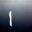

In [25]:
# Visualize imperfect generations 
while True:
    i = random.choice(list(range(len(pilimages))))
    if ACC[i] < 1:
        print("Text prompt:", gth_captions[i])
        print("Score judged by ViT: ", ACC[i])
        f = vit_pred[i]
        print(f"Generated objs judged by ViT: <{classes[f]}>")
        break
print("i = ", i)
pilimages[i]

### Test Finetuned ViT on Generated Samples (two objects)

In [26]:
#18 objs in original whatsup dataset:
#classes = ['empty', 'mug', 'plate', 'book', 'bowl', 'can', 'cap', 'cup', 'remote', 'sunglasses', 
#          'tape', 'candle', 'flower', 'fork', 'headphones', 'scissors', 'spoon', 'knife', 'phone']

#15 objs after removing sunglasses, remote, phone
classes = ['empty', 'book', 'bowl', 'can', 'cap', 'cup', 'mug', 'plate', 'candle', 'flower', 'fork', 'headphones', 'knife', 'scissors', 'spoon', 'tape']
n2i = {n:i for i, n in enumerate(classes)}
device = "cuda"
ckpt_dir = os.path.join(PATH, "autoeval/vit-base-patch16-224-in21k_0311_211459.pt")

In [27]:
def process_gen_sample(pilimage, gth_caption, whichset):
    W, H = pilimage.size
    if W==H: 
        crop1 = pilimage.crop((W//4, 0, 3*W//4, H//2)) # behind
        crop2 = pilimage.crop((W//4, H//2, 3*W//4, H)) # front
        crop3 = pilimage.crop((0, H//4, W//2, 3*H//4)) # left
        crop4 = pilimage.crop((W//2, H//4, W, 3*H//4)) # right
    elif W == 2*H:
        crop3 = pilimage.crop((0, 0, W//2, H)) # left
        crop4 = pilimage.crop((W//2, 0, W, H)) # right
    elif H == 2*W:
        crop1 = pilimage.crop((0, 0, W, H//2)) # behind
        crop2 = pilimage.crop((0, H//2, W, H)) # front
        
    tmp = gth_caption.split()
    if whichset == "train":
        f1, f2 = tmp[1], tmp[-1]
        r = " ".join(tmp[2:-2])
    elif whichset == "test":
        f1, f2 = tmp[0], tmp[-1]
        r = " ".join(tmp[1:-1])
    else: raise ValueError(f"Invalid whichset: {whichset}")
    T = (f1, f2, r)

    if "left of" in r: labels, crops = [n2i[f1], n2i[f2]], [crop3, crop4]
    elif "right of" in r: labels, crops = [n2i[f2], n2i[f1]], [crop3, crop4]
    elif "in-front of" in r: labels, crops = [n2i[f2], n2i[f1]], [crop1, crop2]
    elif "behind" in r: labels, crops = [n2i[f1], n2i[f2]], [crop1, crop2]
    else: raise ValueError(f"Invalid relation: {r}")
    
    return [{
        "image": crop,
        "label": label,
    } for crop, label in zip(crops, labels)], T

In [28]:
handle = "0304_235058"
whichset="train"
sample_dir = f"../scripts/diffuser_real/output/{handle}/samples"

# Load samples saved during training (from epoch 0 to completion)

imsize_h, imsize_w = 32, 64

pilimages, gth_captions = [], []

for f in os.listdir(sample_dir):
    if ".txt" in f: continue
    im = Image.open(f"{sample_dir}/{f}")
    W, H = im.size
    nrows, ncols = H//imsize_h, W//imsize_w
    captions_file = f.replace(".png", ".txt")
    with open(f"{sample_dir}/{captions_file}", "r") as captions:
        gth_captions.extend([x.strip() for x in captions.readlines()])
    for r in range(nrows):
        for c in range(ncols):
            left, top = c*imsize_w, r*imsize_h
            right, bottom = left+imsize_w, top+imsize_h
            pilimage = im.crop((left, top, right, bottom))
            if np.sum(pilimage) == 255*3*imsize_h*imsize_w: continue # skip placeholders which are purely white images
            pilimages.append(pilimage)
    print(len(pilimages), len(gth_captions))

20 20
40 40
60 60
80 80
100 100


In [29]:
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(classes),
    id2label={str(i): c for i, c in enumerate(classes)},
    label2id={c: str(i) for i, c in enumerate(classes)}
)

state_dict = torch.load(ckpt_dir, map_location=device)
model.load_state_dict(state_dict)
model.to(device)
print()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
ACC = []
vit_pred = []
eval_batch_size = 16
outer_batch = []
dataiter = iter(zip(pilimages, gth_captions))

while True:
    try:
        image, text = next(dataiter)
        batch, T = process_gen_sample(image, text, whichset)
        outer_batch.extend(batch)
        if len(outer_batch) == 2*eval_batch_size:
            input_batch = collate_fn(outer_batch)
            labels = input_batch['label'].to(device)
            outputs = model(input_batch['pixel_values'].to(device))['logits']

            for b in range(eval_batch_size):
                acc, pred = get_acc(outputs[2*b:2*b+2], labels[2*b:2*b+2], False)
                ACC.append(acc)
                vit_pred.append(pred)
            outer_batch = []
    except StopIteration:
        if len(outer_batch):
            input_batch = collate_fn(outer_batch)
            labels = input_batch['label'].to(device)
            outputs = model(input_batch['pixel_values'].to(device))['logits']
            for b in range(len(outer_batch)//2):
                acc, pred = get_acc(outputs[2*b:2*b+2], labels[2*b:2*b+2], False)
                ACC.append(acc)
                vit_pred.append(pred)
        break


    

In [31]:
print(len(ACC))
print(np.mean(ACC))
print("ACC autoevaluated by ViT: ", np.mean([a==1 for a in ACC]))

100
0.765
ACC autoevaluated by ViT:  0.69


Text prompt: A can to the left of a fork
Score judged by ViT:  0.5
Generated objs judged by ViT: <fork> on the left, <fork> on the right
i =  28


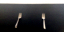

In [33]:
# Visualize imperfect generations 
while True:
    i = random.choice(list(range(len(pilimages))))
    if ACC[i] < 1:
        print("Text prompt:", gth_captions[i])
        print("Score judged by ViT: ", ACC[i])
        f1, f2 = vit_pred[i]
        print(f"Generated objs judged by ViT: <{classes[f1]}> on the left, <{classes[f2]}> on the right")
        break
print("i = ", i)
pilimages[i]